In [1]:
import pandas as pd
import geopandas as gpd
import os
import gtfs_kit as gk
import osmnx as ox

/home/jptalusan/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Get service disruption dataset
fp = os.path.join('data', 'Service Disruptions_07_2019_08_2022.csv')
disruptions_df = pd.read_csv(fp)
disruptions_df.head()
disruptions_df['DATETIME'] = disruptions_df['DATE'] + ' ' + disruptions_df['TIME']
disruptions_df['DATE'] = pd.to_datetime(disruptions_df['DATE'], format='%m/%d/%y', errors='coerce')
disruptions_df['TIME'] = pd.to_datetime(disruptions_df['TIME'], format='%H:%M:%S', errors='coerce')
disruptions_df['DATETIME'] = pd.to_datetime(disruptions_df['DATETIME'], format='%m/%d/%y %H:%M:%S', errors='coerce')

# Remove weather related disruptions
# disruptions_df = disruptions_df[(disruptions_df['REASON'] != 'Weather')].sort_values(by=['DATETIME']).reset_index(drop=True)
print('Shape:', disruptions_df.shape)
# disruptions_df = disruptions_df.drop(columns=['COMMENTS'])
disruptions_df['BLOCK'] = disruptions_df['BLOCK'].astype('int32')

# Convert to spark dataframe for merging
# disruptions_sp = spark.createDataFrame(disruptions_df)
# disruptions_sp = disruptions_sp.withColumn("BLOCK", F.col("BLOCK").cast(IntegerType()))

Shape: (5066, 10)


In [3]:
disruptions_df = gpd.GeoDataFrame(disruptions_df, geometry=gpd.points_from_xy(disruptions_df.START_STOP_LONGITUDE, disruptions_df.START_STOP_LATITUDE))
disruptions_df = disruptions_df.set_crs('EPSG:4326')
disruptions_df = disruptions_df[['DATETIME', 'BLOCK', 'REASON', 'COMMENTS', 'START_STOP_ABBR', 'geometry']]
disruptions_df.head()

,DATETIME,BLOCK,REASON,COMMENTS,START_STOP_ABBR,geometry
0,2020-05-11 16:31:00,1400,Passenger Incident,"Passenger Incident, 99 opr to cover outbound...jf",WHIMOONN,POINT (-86.80345 36.21818)
1,2020-06-22 06:32:00,1400,Accident,"Accident,Bus not involved,No 99 needed at this...",WHIMOONN,POINT (-86.80345 36.21818)
2,2020-06-26 07:15:00,1400,Mechanical,"Mechanical, 99 covered outbound trip",MCC4_20,POINT (-86.78192 36.16709)
3,2020-08-06 16:15:00,1400,Accident,"Accident along route, 99 covered the OB trip-DB",MCC4_20,POINT (-86.78192 36.16709)
4,2020-10-15 06:38:00,1400,Mechanical,"Mechanical,99 covered inbound trip",ROWBUESN,POINT (-86.81951 36.21714)


In [4]:
fp = '/home/jptalusan/gits/mta_simulator_redo/data_generation/data/GTFS/OCT2021/gtfs.zip'
feed = gk.read_feed(fp, dist_units='km')
feed.validate()

,type,message,table,rows
1,error,Invalid arrival_time; maybe has extra space ch...,stop_times,"[369, 370, 371, 372, 373, 374, 375, 376, 377, ..."
2,error,Invalid departure_time; maybe has extra space ...,stop_times,"[369, 370, 371, 372, 373, 374, 375, 376, 377, ..."
0,warning,Feed expired,calendar/calendar_dates,[]


In [5]:
stops_df = gk.get_stops(feed)[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]
stops_df = gpd.GeoDataFrame(stops_df, geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat))
stops_df = stops_df.set_crs('EPSG:4326')
stops_df.head(1)

,stop_id,stop_name,stop_lat,stop_lon,geometry
0,10AHERNN,10TH AVE N & HERMAN ST NB,36.168831,-86.792339,POINT (-86.79234 36.16883)


In [6]:
disruptions_df = pd.merge(disruptions_df, stops_df[['stop_id', 'geometry']], left_on='START_STOP_ABBR', right_on='stop_id', how='left', suffixes=("_report", "_gtfs"))
disruptions_df = disruptions_df.rename({"geometry_gtfs":"geometry"}, axis=1)
disruptions_df = disruptions_df.set_geometry("geometry")
# Assign disruption report geometry to overall geometry if couldn't find match
disruptions_df.loc[disruptions_df['stop_id'].isnull(), 'geometry'] = disruptions_df[disruptions_df['stop_id'].isnull()]['geometry_report']

In [7]:
mapbox_access_token = "pk.eyJ1Ijoidmlzb3ItdnUiLCJhIjoiY2tkdTZteWt4MHZ1cDJ4cXMwMnkzNjNwdSJ9.-O6AIHBGu4oLy3dQ3Tu2XA"
MAPBOX_ACCESS_TOKEN = mapbox_access_token

In [8]:
fp = os.path.join('data', 'shapefiles', "tncounty")
gdf_county = gpd.read_file(fp)
gdf_dav = gdf_county[gdf_county["NAME"] == "Davidson"]
gdf_dav = gdf_dav.to_crs("EPSG:4326")

fp_G = os.path.join('data', 'davidson_graph.graphml')
if not os.path.exists(fp_G):
    G = ox.graph_from_polygon(gdf_dav.geometry.iloc[0], network_type='drive')
    # G = ox.add_edge_speeds(G)
    # G = ox.add_edge_travel_times(G)

    ox.save_graphml(G, fp_G)
else:
    G = ox.load_graphml(fp_G)

nodes, edges = ox.graph_to_gdfs(G)

In [9]:
fp = os.path.join('data', 'inrix_grouped.pkl')
inrix_grouped = pd.read_pickle(fp)
inrix_grouped = inrix_grouped.set_geometry('geometry')
inrix_grouped = inrix_grouped[inrix_grouped.within(gdf_dav.geometry.iloc[0])]
# inrix_grouped = inrix_grouped.to_crs("EPSG:4326")
inrix_grouped.head(1)

,geometry,XDSegID,PreviousXD,NextXDSegI,FRC,County_inrix,Miles,Lanes,SlipRoad,StartLat,...,WayStartOffset_m,WayEndOffset_m,WayStartOffset_percent,WayEndOffset_percent,iSF_length,iSF_length_min,Nearest_Weather_Station,MyGrouping_3,MyGrouping_3_id,MyGrouping_3_id_miles
5954,"LINESTRING (-86.770 36.120, -86.770 36.120)",155711459.0,NaN,NaN,4,davidson,0.027042,1.0,False,36.1199,...,404.08,447.6,48.607,53.842,1.0,1.0,723270-13897,8109150,NaN,NaN


In [10]:
# https://stackoverflow.com/questions/70436611/fast-way-to-check-if-a-list-of-points-is-close-to-a-list-of-linestrings-in-pytho
# find nearest line to each point (hospital)
def nr_dist():
    gdfn = gpd.sjoin_nearest(
        disruptions_df,
        inrix_grouped
    ).merge(inrix_grouped["geometry"], left_on="index_right", right_index=True, suffixes=("","_line"))
    # calc the distance between the point and linestring
    gdfn["distance"] = gdfn.apply(lambda r: r["geometry_line"].distance(r["geometry"]), axis=1)
    return gdfn

# %timeit gdfn = nr_dist()
gdfn = nr_dist()
gdfn.head(1)
tdf = gdfn[['DATETIME', 'BLOCK', 'REASON', 'XDSegID', 'Lanes', 'Miles', 'OSMWayIDs', 'geometry_line', 'distance', 'iSF_length', 'iSF_length_min', 'Bearing']]
tdf = pd.merge(disruptions_df, tdf, on=['DATETIME', 'BLOCK', 'REASON'], how='left')
tdf = tdf.drop_duplicates(subset=['DATETIME', 'BLOCK', 'REASON'], keep='first')
tdf['hour'] = tdf['DATETIME'].dt.hour
tdf['month'] = tdf['DATETIME'].dt.month
tdf['dayofweek'] = tdf['DATETIME'].dt.dayofweek
tdf = tdf[tdf.within(gdf_dav.geometry.iloc[0])]

/tmp/ipykernel_118222/1676473668.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3310

  gdfn = gpd.sjoin_nearest(
/home/jptalusan/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


## Clustering based on spatial features only

In [31]:
from sklearn.cluster import KMeans
from copy import deepcopy

_tdf = deepcopy(tdf)
_tdf['lat'] = tdf['geometry_report'].x
_tdf['lon'] = tdf['geometry_report'].y
kmeans = KMeans(n_clusters=4, random_state=0).fit(_tdf[['lat', 'lon']].to_numpy())
_tdf['labels'] = kmeans.labels_
_tdf['labels'].value_counts()

1    3077
0     786
2     758
3     391
Name: labels, dtype: int64

In [35]:
polys = []
for label, label_df in _tdf.groupby('labels'):
    env = label_df.unary_union.minimum_rotated_rectangle
    polys.append((label, env))

In [36]:
import numpy as np
import networkx as nx

depots = []
for label, poly in polys:
    G = ox.graph_from_polygon(poly, network_type='drive', truncate_by_edge=True)
    p = stops_df[stops_df.within(poly)].reset_index()
    a = ox.nearest_nodes(G, X=p.geometry.x, Y=p.geometry.y, return_dist=True)
    p = pd.merge(p, pd.DataFrame(a).T, left_index=True, right_index=True)
    p = p.rename({0:'nearest_node', 1:'distance'}, axis=1)
    average_distance_to_all = []
    
    if label != 1:
        for k, v in p.iterrows():
            nearest_node = v['nearest_node']
            all_nodes = p.nearest_node.tolist()
            distance = []
            for node in all_nodes:
                try:
                    spl = nx.shortest_path_length(G, nearest_node, node)
                    distance.append(spl)
                except:
                    distance.append(np.nan)
                
            average_distance_to_all.append(np.nanmean(np.asarray(distance)))
        
        p['average_distance_to_all'] = average_distance_to_all
        p.sort_values('average_distance_to_all')
        
        center_stop = p.sort_values('average_distance_to_all').iloc[0].stop_id
        depots.append((label, center_stop))
    # fig, ax = ox.plot_graph(
    #     G, node_color='black', node_size=1, edge_linewidth=2, edge_color="#555555", show=False
    # )
    # center = p.sort_values('average_distance_to_all').iloc[0].geometry
    # ax.plot(*center.centroid.xy, marker='^', markersize=10, color='red')
    # p.plot(ax=ax, marker='s', markersize=5)
    # plt.savefig(f"{label}.png", dpi=200)
depots.append((1, 'MTA'))
depots.append((1, 'MCC5_1'))

In [37]:
depots

[(0, 'GLASOUWN'), (2, 'DWMRT'), (3, 'WHICHASF'), (1, 'MTA'), (1, 'MCC5_1')]

In [41]:
geometry

,current_node,next_node,travel_time_s,distance_m,current_stop,next_stop
0,202342839,202342839,0.0,0.000,12ADEMNN,12ADEMNN
1,202342839,202342839,0.0,0.000,12ADEMNN,11ADEMSF
2,202342839,202342839,0.0,0.000,11ADEMSF,12ADEMNN
3,202342839,202342839,0.0,0.000,11ADEMSF,11ADEMSF
4,202342839,202342839,0.0,0.000,12ADEMNN,12ADEMNN
...,...,...,...,...,...,...
23164964,202242866,2546443756,1276.0,21400.466,VILBRIEM,WALBROEM
23164965,2546443756,2546443756,0.0,0.000,WALBROEM,WALBROEM
23164966,202300606,2546443756,736.5,11585.342,WED21AEF,WALBROEM
23164967,202263644,2546443756,876.1,13443.758,WES29AWN,WALBROEM


['GLASOUWN']
['MTA', 'MCC5_1']
['DWMRT']
['WHICHASF']


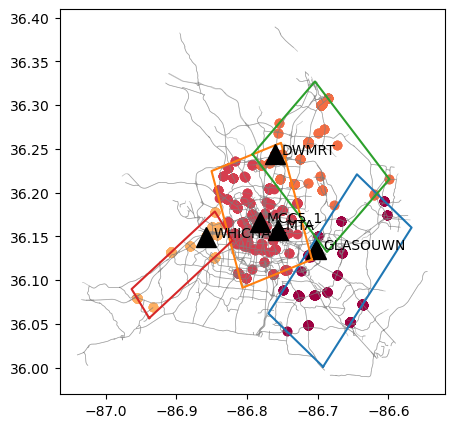

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
inrix_grouped.plot(lw=0.5, color='gray', ax=ax, alpha=0.5)
colors = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#ffffbf','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2']

for label, label_df in _tdf.groupby('labels'):
    label_df.plot(color=colors[label], ax=ax)
    env = label_df.unary_union.minimum_rotated_rectangle
    _depots = [_d[1] for _d in depots if _d[0] == label]
    print(_depots)
    for d in _depots:
        center = stops_df.query("stop_id == @d").iloc[0].geometry
        
        # sometimes the center stop is not available
        a = feed.geometrize_stops()
        idx = a.sindex.nearest(center)[1]
        d = a.iloc[idx].iloc[0].stop_id
        center = a.iloc[idx].iloc[0].geometry
        
        ax.plot(*center.centroid.xy, marker='^', markersize=15, color='black')
        ax.text(x=center.centroid.x + 0.01, y=center.centroid.y, s=d)
    ax.plot(*env.exterior.xy)

# plt.savefig('kmeans_map.eps', format='eps')